In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2025-04-15 09:01:46.109154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744682506.145013   79634 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744682506.156521   79634 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744682506.183996   79634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744682506.184034   79634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744682506.184038   79634 computation_placer.cc:177] computation placer alr

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 7

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

W0000 00:00:1744682513.101363   79634 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,147 (4.48 KB)

 Trainable params: 1,147 (4.48 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
27/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2592 - loss: 1.8891 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3007 - loss: 1.8509 - val_accuracy: 0.5036 - val_loss: 1.5615
Epoch 2/1000
31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4889 - loss: 1.5638 
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4895 - loss: 1.5465 - val_accuracy: 0.5386 - val_loss: 1.3103
Epoch 3/1000
35/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4969 - loss: 1.3976 
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5018 - loss: 1.3833 - val_accuracy: 0.5889 - val_loss: 1.1570
Epoch 4/1000
37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5212 - loss: 1.2881 
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.2525 


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[1.9336378e-02 4.7780275e-02 9.3255270e-01 3.0457546e-04 1.0179235e-05
 1.5733163e-05 6.1343881e-14]
2


# Confusion matrix

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


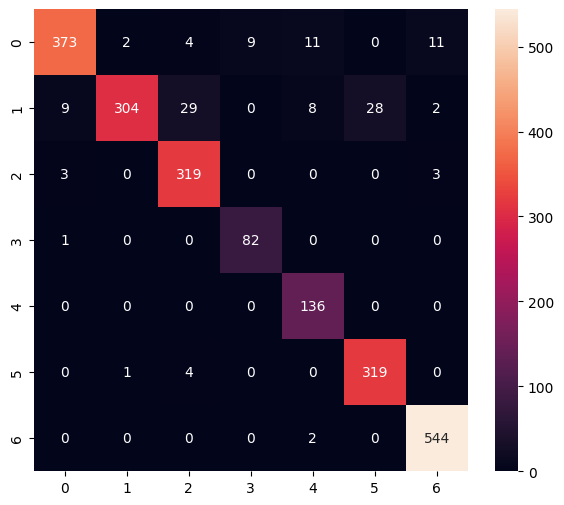

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       410
           1       0.99      0.80      0.89       380
           2       0.90      0.98      0.94       325
           3       0.90      0.99      0.94        83
           4       0.87      1.00      0.93       136
           5       0.92      0.98      0.95       324
           6       0.97      1.00      0.98       546

    accuracy                           0.94      2204
   macro avg       0.93      0.95      0.94      2204
weighted avg       0.95      0.94      0.94      2204



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpn7qq6r4u/assets


INFO:tensorflow:Assets written to: /tmp/tmpn7qq6r4u/assets


Saved artifact at '/tmp/tmpn7qq6r4u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132836941590224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132836941594256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132836939039952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132836939054544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132836939042448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132836939053392: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1744682557.792284   79634 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744682557.792306   79634 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-15 09:02:37.792645: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn7qq6r4u
2025-04-15 09:02:37.793168: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-15 09:02:37.793175: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpn7qq6r4u
I0000 00:00:1744682557.797466   79634 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-15 09:02:37.798534: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-15 09:02:37.818298: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpn7qq6r4u
2025-04-15 09:02:37.824527: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

6688

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/mnt/01DB783D25219E60/HOMEWORK/TGMT/ThiGiacPC/AI/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time: 1.17 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.9336378e-02 4.7780249e-02 9.3255287e-01 3.0457554e-04 1.0179237e-05
 1.5733165e-05 6.1343888e-14]
2
